In [0]:
from time import process_time
from keras.datasets import mnist
from random import randint
from matplotlib import pyplot as plt
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.decomposition import KernelPCA

import pandas as pd
import numpy as np

Using TensorFlow backend.


In [0]:
# Load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train) = shuffle(x_train, y_train)

11493376/11490434 [==============================] - 1s 0us/step


# **PART I: Code**

In [0]:
# Perform principal component analysis.
def pca(X):
    means = np.mean(X.T, axis=1)
    centered = X - means
    cov = np.cov(centered.T)
    weights, vectors = np.linalg.eigh(cov)
    return means, weights, vectors

# Get the projection of the input matrix.
def projection(vectors, centered):
    return vectors.T.dot(centered.T)

In [0]:
# Sampling
size = 1000
sample_X = []
sample_y = []

for i in range(size):
    index = randint(0,len(x_train) - 1)
    sample_X.append(x_train[index])
    sample_y.append(y_train[index])
    
# We use each pixel value as a feature so we have 28*28=784 features totally.
# Flatten the data before applying PCA.
sample_X = np.array(sample_X).reshape((size, sample_X[0].shape[0]*sample_X[0].shape[1]))
sample_y = np.array(sample_y)

scaler = StandardScaler()
sample_X = scaler.fit_transform(sample_X)
print(sample_X.shape, 'total number of features =', sample_X.shape[1])

(1000, 784) total number of features = 784


## Part I: Results

In [0]:
means, weights, vectors = pca(sample_X)
centered = sample_X - means
project = projection(vectors, centered).T
eigens = [(np.abs(weights[i]), project[:,i]) for i in range(len(weights))]
eigens.sort(key=lambda x: x[0], reverse=True)
weights = list(zip(*eigens))[0]
P = np.array(list(zip(*eigens))[1])

In [0]:
# Calculate explained variance ratio for all eigenvectors by using eigenvalues
explained_variance = [i * 100 / sum(weights) for i in weights]

Stop at the first index with 95% variance(Lets say it is 190. Then, we need 190 components to explain our original data with %95 variance ratio).

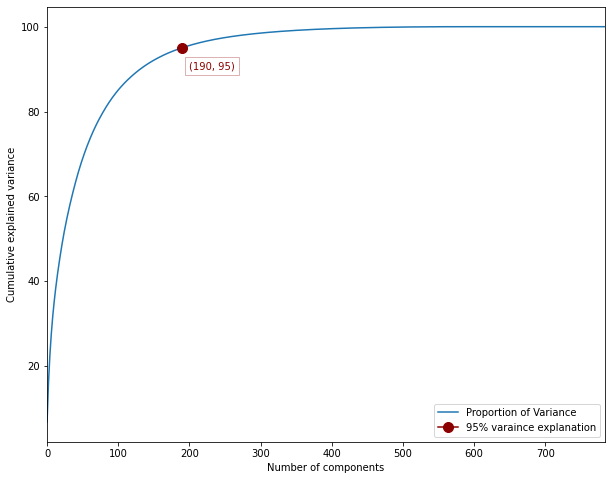

In [0]:
cumsum = np.cumsum(explained_variance)
y = 95
x = np.argmax(cumsum >= y)
plt.figure(figsize=(10, 8))
plt.plot(cumsum, label='Proportion of Variance')
plt.plot(x, y, marker='o', markersize=10, color="darkred", label='95% varaince explanation')
plt.text(x+10, y-5, '({}, {})'.format(x, y), color="darkred", bbox=dict(facecolor='none', alpha=0.3, edgecolor='darkred'))
plt.legend(loc='lower right')
plt.xlim(0,len(explained_variance),1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

## Part I: Conclusions

Here we flatten 1000 samples of 28x28 we have. Thus, the entire input matrix is defined as a 1000x764 matrix. We have followed these steps for the matrix:

1.   Subtract average matrice from original matris to put the original matrice in center.
2.   We found the covariance matrix of the centered matrix.
3.   Using the covariance matrix, we created the eigenvalues and their eigenvalue vectors.
4.   Using the eigenvalues, we rank from large to small, and illustrated how much principal component is required to explain the variance value of 95% as an example.


# PART II: Code

## PART II - A: Code

In [0]:
# delete eigenvectors with zero eigenvalue(It may not be necessary for this task).
P = P[np.nonzero(weights)]

# number of principal components = 10
pc10 = P.T[:, 0:10]

# number of principal components = 20
pc20 = P.T[:, 0:20]

# number of principal components = 40
pc40 = P.T[:, 0:40]

# number of principal components = 100
pc100 = P.T[:, 0:100]

# number of principal components = 200
pc200 = P.T[:, 0:200]

print(pc10.shape, pc20.shape, pc40.shape, pc100.shape, pc200.shape)

(1000, 10) (1000, 20) (1000, 40) (1000, 100) (1000, 200)


## Part II - B: Code

This part is made with a 10-component projection.


In [0]:
labels = np.unique(sample_y)

In [0]:
def generate_colors():
    # color generator: https://stackoverflow.com/questions/13998901/generating-a-random-hex-color-in-python
    colors = []
    r = lambda: randint(0,255)
    for i in range(len(labels)):
        colors.append('#%02X%02X%02X' % (r(),r(),r()))
    return colors

def plot_pca(data, pcs):
    df = pd.DataFrame(data[:, pcs])
    df['label'] = sample_y
    first = 'PC' + str(pcs[0]+1)
    second = 'PC' + str(pcs[1]+1)

    df.columns = [first, second, 'label']

    colors = generate_colors()
    
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1,1,1) 
    ax.set_title('Principal Components')
    ax.set_xlabel(first) 
    ax.set_ylabel(second)
    ax.set_xlim(df[first].min()-1, df[first].max()+1)
    ax.set_ylim(df[second].min()-1, df[second].max()+1)
    for label, color in zip(labels, colors):
        indicesToKeep = df['label'] == label
        ax.scatter(df.loc[indicesToKeep, first], 
                   df.loc[indicesToKeep, second],
                   c = color, s = 20)
    ax.legend(labels)
    ax.grid()

### Part II - B: Results

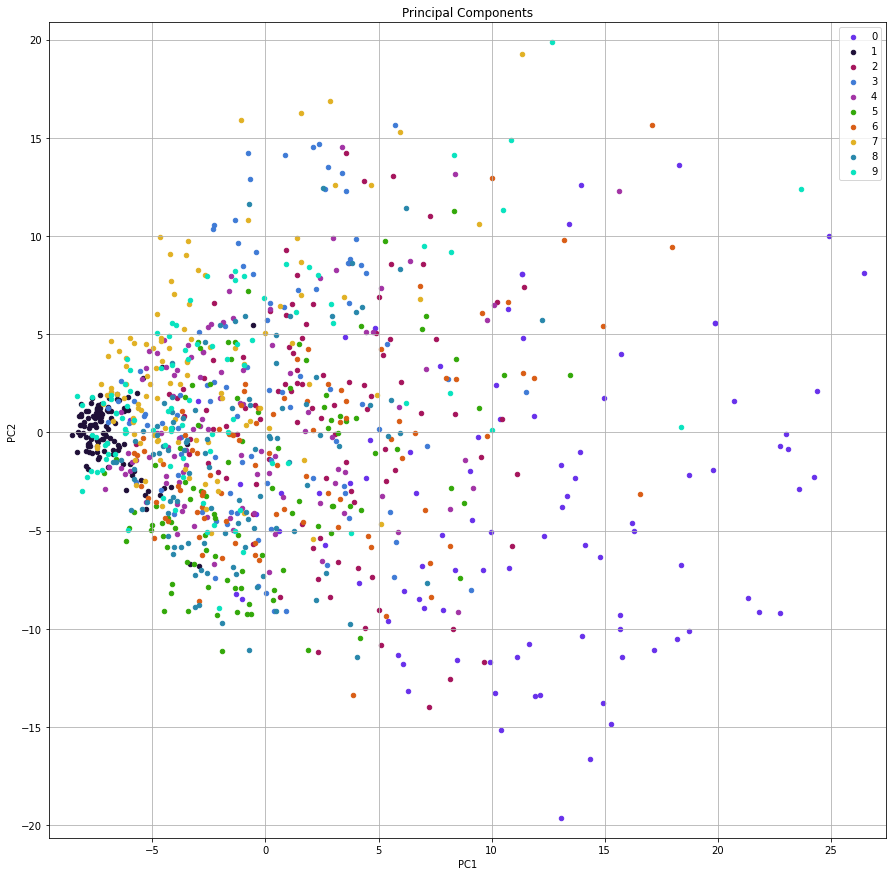

In [0]:
plot_pca(pc10, [0, 1])

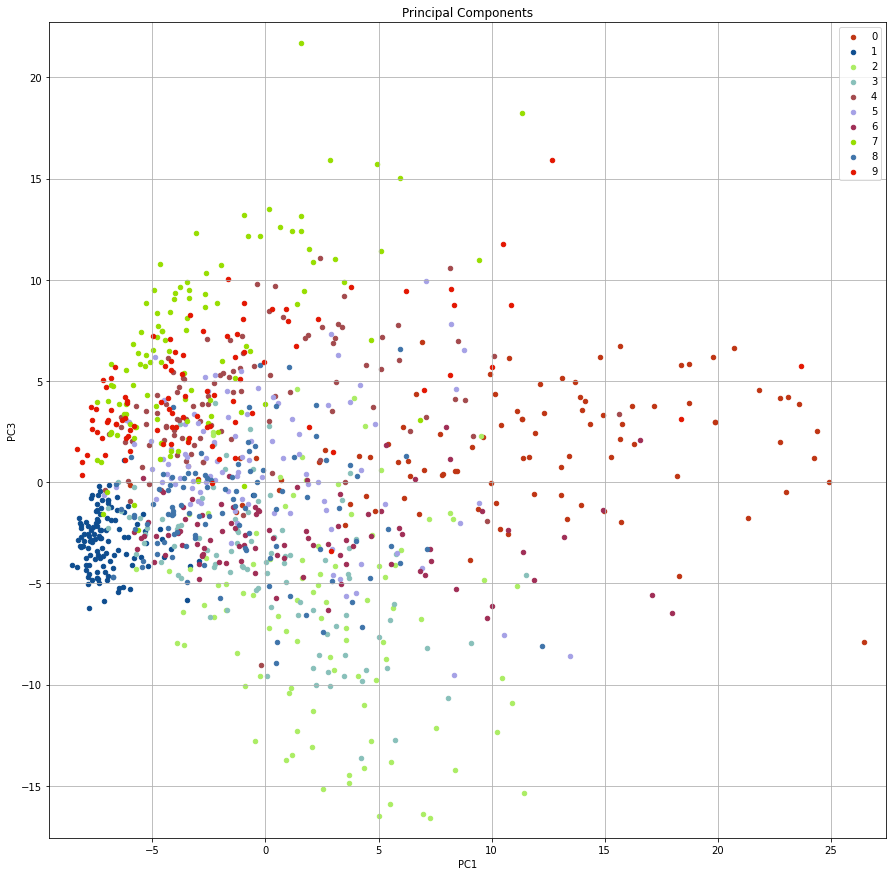

In [0]:
 plot_pca(pc10, [0, 2])

## Part II - C: Code

In [0]:
def random_forest(X, y, n_components):
    classifier = RandomForestClassifier(n_estimators=100)
    k = 5
    cv = StratifiedKFold(n_splits=k, shuffle=False)
    scores = []
    for (train, test), i in zip(cv.split(X, y), range(k)):
        classifier.fit(X[train], y[train])
        y_pred=classifier.predict(X[test])
        scores.append(accuracy_score(y[test], y_pred))
    print('===========================================')
    print('Number of principal components:', n_components)
    print(k, 'fold cross validation:')
    print(pd.DataFrame(scores, columns=['Accuracy']), end='\n\n')
    print('Average accuracy score is', np.mean(scores), 'with', np.std(scores), 'standard deviation.\n\n')

### Part II - C Results:

In [0]:
# Random forest without dimensionality reduction
random_forest(sample_X, sample_y, len(sample_X[0]))

Number of principal components: 784
5 fold cross validation:
   Accuracy
0     0.885
1     0.865
2     0.880
3     0.885
4     0.885

Average accuracy score is 0.8799999999999999 with 0.007745966692414841 standard deviation.




In [0]:
random_forest(pc10, sample_y, len(pc10[0]))
random_forest(pc20, sample_y, len(pc20[0]))
random_forest(pc40, sample_y, len(pc40[0]))
random_forest(pc100, sample_y, len(pc100[0]))
random_forest(pc200, sample_y, len(pc200[0]))

Number of principal components: 10
5 fold cross validation:
   Accuracy
0     0.815
1     0.835
2     0.845
3     0.760
4     0.800

Average accuracy score is 0.8109999999999999 with 0.02989983277545209 standard deviation.


Number of principal components: 20
5 fold cross validation:
   Accuracy
0     0.860
1     0.870
2     0.855
3     0.820
4     0.835

Average accuracy score is 0.8480000000000001 with 0.018055470085267804 standard deviation.


Number of principal components: 40
5 fold cross validation:
   Accuracy
0     0.870
1     0.890
2     0.850
3     0.825
4     0.835

Average accuracy score is 0.8539999999999999 with 0.02353720459187966 standard deviation.


Number of principal components: 100
5 fold cross validation:
   Accuracy
0     0.815
1     0.905
2     0.880
3     0.810
4     0.810

Average accuracy score is 0.8440000000000001 with 0.04042276586281547 standard deviation.


Number of principal components: 200
5 fold cross validation:
   Accuracy
0     0.845
1     0.855
2

## Part II: Conclusions

In this section, we used the eigenvalue vectors and obtained different projections (linear combination) of the original input we have. We tested 5 different projections: pc10, pc20, pc40, pc100 and pc200 with random forest algorithm. Even when we used 10 components instead of 764 components, we observed that the accuracy was not affected drastically.

We also created two graphs of the principal components. We created pc1, pc2 and pc1, pc3 graphics from pc1, pc2 and pc3 components with the highest variance value(pc1>pc2>pc3). We observed that there are certain clusters in the graphics. Of course, we can observe that these clusters are clearer when more than 1000 samples are used. In addition, we have seen that although the variance rate explained by these 3 components is large, not all clusters are large enough to be clearly distinguished.

# **PART III: Code**

In [0]:
def kernel_PCA(X, y, n_components):
    # kernels: linear | poly | rbf | sigmoid | cosine | precomputed
    transformer = KernelPCA(n_components=n_components, kernel='sigmoid')
    X_transformed = transformer.fit_transform(X)
    random_forest(X_transformed, y, n_components)

## Part III: Results

In [0]:
kernel_PCA(sample_X, sample_y, 10)
kernel_PCA(sample_X, sample_y, 20)
kernel_PCA(sample_X, sample_y, 40)
kernel_PCA(sample_X, sample_y, 100)
kernel_PCA(sample_X, sample_y, 200)

Number of principal components: 10
5 fold cross validation:
   Accuracy
0     0.835
1     0.855
2     0.820
3     0.795
4     0.785

Average accuracy score is 0.818 with 0.02561249694973137 standard deviation.


Number of principal components: 20
5 fold cross validation:
   Accuracy
0     0.865
1     0.890
2     0.890
3     0.845
4     0.845

Average accuracy score is 0.867 with 0.020149441679609904 standard deviation.


Number of principal components: 40
5 fold cross validation:
   Accuracy
0     0.845
1     0.890
2     0.875
3     0.850
4     0.830

Average accuracy score is 0.858 with 0.021587033144922923 standard deviation.


Number of principal components: 100
5 fold cross validation:
   Accuracy
0     0.835
1     0.845
2     0.880
3     0.790
4     0.840

Average accuracy score is 0.8380000000000001 with 0.028740215726399815 standard deviation.


Number of principal components: 200
5 fold cross validation:
   Accuracy
0     0.815
1     0.825
2     0.795
3     0.745
4     0.790

A

## Part III: Conclusions

The linear pca on part1 performs similar to scikit-learn's kernel pca. In some cases it works well, in some cases not. But the difference is very small. Since Linear dependency is important in principal components, it may be normal to get this result. On the other hand, it was sigmoid that gave the best performance of scikit-learn's nonlinear kernels.

Finally, we obtained more accuracy when we used 1000 samples (1000x764) directly. PCA does not always have to make improvements. In many cases, this is why it is usual to encounter this situation, since there is noise in the training data. However, we can still choose to compress data for very little loss. Thus, we can get faster computation.